# 옷의 feature 추출
---

방식
    
    CNN 모델을 통해 옷 이미지로부터 feature 추출  
  
사용할 모델

1. 우리가 훈련한 모델

2. pretrained 모델  
    사실 그냥 pretrained 모델들의 weight를 그대로 써도 무방하다  
    이유 : 동일 모델에 데이터를 넣으면 동일한 기준으로 추출되므로 유사성이 보존될 것이다라는 추측

In [1]:
import os

os.chdir('..')

In [2]:
#tensorflow.keras.resnet50 과 keras.resnet50은 shape incompatible함 ㅜㅜ
#keras_pretrained에 저장된 weight를 쓸거면 keras를
#그냥 imagenet으로 쓸거면 tf.keras를
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model

import pickle

In [3]:
from tqdm.notebook import tqdm

## 데이터 준비

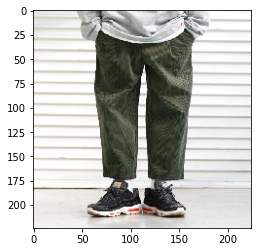

In [4]:
#모델의 사이즈인 224,224에 맞게 변경
img = image.load_img("data/musinsa/48515.jpg", target_size=(224, 224))

#이미지 확인
plt.imshow(img)

In [5]:
#PIL 이미지를 numpy array로 변경
x = image.img_to_array(img)

#array shape 확인
x.shape

(224, 224, 3)

In [6]:
# Add a forth dimension since Keras expects a list of images
x = np.expand_dims(x, axis=0)

x.shape

(1, 224, 224, 3)

In [7]:
# Scale the input image to the range used in the trained network
x = resnet50.preprocess_input(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


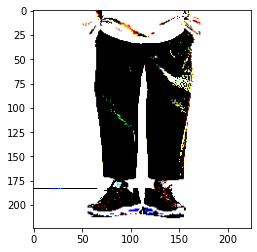

In [8]:
#전처리된 이후의 이미지 확인
plt.imshow(x.squeeze(0))

## 모델 생성 - 기존 pretrained 모델 불러오기 및 형태 확인

In [9]:
#테스트용으로 사용할 모델 - Keras Pretrained ResNet 50
RESNET50_WEIGHTS = 'models/keras_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
RESNET50_NOTOP_WEIGHTS = 'models/keras_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
#top과 notop의 차이점
model = resnet50.ResNet50(weights=RESNET50_WEIGHTS)
model_notop = resnet50.ResNet50(weights=RESNET50_NOTOP_WEIGHTS,include_top=False)

In [ ]:
#top/notop 차이 확인
#notop은 input/output layer가 없음
#notop은 따라서 input shape를 넣어줘야 함
print("----with top-----")
print("first 5 layer")
for i in range(0,5) :
    print(model.layers[i] , model.layers[i].output_shape)

print("\nlast 5 layer")
for i in range(-5,0) :
    print(model.layers[i] , model.layers[i].output_shape)
    
    
print("\n----without top-----")
print("first 5 layer")
for i in range(0,5) :
    print(model_notop.layers[i] , model_notop.layers[i].output_shape)

print("\nlast 5 layer")
for i in range(-5,0) :
    print(model_notop.layers[i] , model_notop.layers[i].output_shape)

## 모델 생성 - pretrained 모델 형태 변경

In [11]:
#테스트용으로 사용할 모델 - Keras Pretrained ResNet 50
name = "resnet50"
RESNET50_WEIGHTS = 'models/keras_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
RESNET50_NOTOP_WEIGHTS = 'models/keras_pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
# 모델 불러오기
#pretrained_model = resnet50.ResNet50(weights=RESNET50_WEIGHTS)
name = "resnet50"
pretrained_model = resnet50.ResNet50(weights="imagenet")

print('Output_layer_type= {}'.format(pretrained_model.layers[-1]))
print('Output_layer_shape= {}'.format(pretrained_model.layers[-1].output_shape))
print("모델 layer 깊이 :",len(pretrained_model.layers))

Output_layer_type= <tensorflow.python.keras.layers.core.Dense object at 0x000002197647C9C8>
Output_layer_shape= (None, 1000)
모델 layer 깊이 : 177


In [13]:
#output layer 근처 5 layer 형태 파악
for i in range(-5,0) :
    print(pretrained_model.layers[i] , pretrained_model.layers[i].output_shape)

<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000219763E3948> (None, 7, 7, 2048)
<tensorflow.python.keras.layers.merge.Add object at 0x00000219763F0BC8> (None, 7, 7, 2048)
<tensorflow.python.keras.layers.core.Activation object at 0x00000219763F0A88> (None, 7, 7, 2048)
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x000002178AB1C708> (None, 2048)
<tensorflow.python.keras.layers.core.Dense object at 0x000002197647C9C8> (None, 1000)


In [14]:
#(만약 output layer를 바꾸고 싶다면) 새로운 모델 생성

new_model = Model(pretrained_model.inputs, pretrained_model.layers[-2].output)  # assuming you want the 3rd layer from the last

new_model.layers[-1].output_shape

(None, 2048)

## 모델 만들기 - Zalando Example (VGG16)

https://towardsdatascience.com/zalando-dress-recomendation-and-tagging-f38e1cbfc4a9

In [ ]:
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

## feature 추출
---
feature vector의 형태

feature vector의 차원과 성능의 관계

    너무 커도 안좋고 너무 작아도 안좋다
    크면 : size가 커져 handling이 어려움. Clustering 등에서 차원의 저주 발생.  
    feature 하나하나의 중요도가 급격히 떨어지고 feature간 종속관계로 인한 정보의 밀도가 낮아짐
    작으면 : feature가 축소되는 과정에서 원래의 이미지가 갖고 있는 정보들이 손실됨
    
최종 size 결정

    512/1024/2048/4096 순으로 변경해가면서 test
    (Zalando 튜토리얼에서는 4096으로 했음)

In [4]:
import pymysql
import json

def connect_db(dbinfo_path) :
    with open(dbinfo_path) as jsonfile :
        dbinfo = json.load(jsonfile)

    connection = pymysql.connect(host=dbinfo['host'],
                         port=dbinfo['port'],
                         user=dbinfo['user'], 
                         passwd=dbinfo['passwd'],
                         db=dbinfo['db'],
                         charset=dbinfo['charset'])
    
    return connection

In [5]:
db = connect_db('dbinfo-temp.json')
cur = db.cursor()

feature 추출 1 - 임의데이터 3000개로부터 feature 추출

In [ ]:
cur = db.cursor()
sql = """SELECT clothes_id,minor FROM CLOTHES_AND_CLOTHES_CLASS 
INNER JOIN CLOTHES ON CLOTHES.id = CLOTHES_AND_CLOTHES_CLASS.clothes_id 
INNER JOIN CLOTHES_CLASS ON CLOTHES_AND_CLOTHES_CLASS.clothes_class_id = CLOTHES_CLASS.id
WHERE clothes_class_id IN 
(SELECT id FROM CLOTHES_CLASS 
WHERE (major="남" OR major="여") 
AND (middle != "" AND middle != "가방" AND middle!="스포츠/용품")) 
ORDER  BY clothes_id ASC 
LIMIT 3000;"""

cur.execute(sql)

In [ ]:
#이미지 번호와 result를 각각 train/test dict로 저장
#평균 20it/sec
train_result_dict = {}
for id, _ in  tqdm(cur) :
    try :
        img = image.load_img("data/musinsa/{}.jpg".format(id), target_size=(224, 224))
    except :
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    result = pretrained_model.predict(x)
    
    train_result_dict[id] = result

카테고리별 feature 확보

In [15]:
#minor 카테고리별 개수 파악
#DB내 카테고리별 개수 파악후, 최소값이라기보단 최대값 n개로 한정해서 최대 n*80개 feature 셋 확보
#내가보기에 어차피 사용자의 시선이 좁은 것을 감안하면 카테고리당 최대 1000개만 해도 충분할 것 같음

sql = """SELECT clothes_class_id, major,minor 
FROM CLOTHES_AND_CLOTHES_CLASS 
INNER JOIN CLOTHES_CLASS ON CLOTHES_AND_CLOTHES_CLASS.clothes_class_id = CLOTHES_CLASS.id 
GROUP BY clothes_class_id 
HAVING (major="남" OR major="여") AND major!="아동" 
AND minor NOT LIKE "(%" AND minor!="웨이스트 백" AND minor!="기능성 상의" AND minor!="기능성 하의";"""

cur.execute(sql)

78

In [16]:
minor_id_map = {}
for id,major,minor in cur :
    minor_id_map[id] = (major,minor)

In [17]:
minor_id_map

{52: ('남', '반팔 티셔츠'),
 53: ('여', '반팔 티셔츠'),
 54: ('남', '긴팔 티셔츠'),
 55: ('여', '긴팔 티셔츠'),
 56: ('여', '민소매 티셔츠'),
 57: ('남', '민소매 티셔츠'),
 58: ('남', '셔츠/블라우스'),
 59: ('여', '셔츠/블라우스'),
 60: ('남', '피케/카라 티셔츠'),
 61: ('여', '피케/카라 티셔츠'),
 62: ('남', '맨투맨/스웨트셔츠'),
 63: ('여', '맨투맨/스웨트셔츠'),
 64: ('남', '후드 스웨트셔츠/후드 집업'),
 65: ('여', '후드 스웨트셔츠/후드 집업'),
 66: ('여', '니트/스웨터/카디건'),
 67: ('남', '니트/스웨터/카디건'),
 68: ('여', '베스트'),
 69: ('남', '베스트'),
 70: ('남', '기타 상의'),
 71: ('여', '기타 상의'),
 72: ('여', '블루종/MA-1'),
 73: ('남', '블루종/MA-1'),
 74: ('남', '레더/라이더스 재킷'),
 75: ('여', '레더/라이더스 재킷'),
 76: ('남', '트러커 재킷'),
 77: ('여', '트러커 재킷'),
 78: ('여', '수트/블레이저 재킷'),
 79: ('남', '수트/블레이저 재킷'),
 80: ('남', '아노락 재킷'),
 81: ('여', '아노락 재킷'),
 82: ('남', '나일론/코치  재킷'),
 83: ('여', '나일론/코치  재킷'),
 84: ('남', '기타 아우터'),
 85: ('남', '트레이닝 재킷'),
 86: ('여', '트레이닝 재킷'),
 87: ('남', '스타디움 재킷'),
 88: ('여', '스타디움 재킷'),
 89: ('남', '환절기 코트'),
 90: ('여', '환절기 코트'),
 91: ('남', '겨울 싱글 코트'),
 92: ('여', '겨울 싱글 코트'),
 93: ('남', '겨울 기타 코트'),
 94: (

In [21]:
#minor 카테고리별로 쿼리 요청해서 카테고리 내 존재하는 옷들의 id와 path 확보
#먼저 id부터 받고-> 경로 저장
def get_clothes_in_minor(minor_id) :
    sql = """SELECT clothes_id FROM CLOTHES_AND_CLOTHES_CLASS
            WHERE clothes_class_id={} LIMIT 1000;""".format(minor_id)

    cur.execute(sql)
    
    id_path_map = {}
    for id in cur :
        id_path_map[id[0]] = "data/musinsa/{}.jpg".format(id[0])
    
    return id_path_map

In [23]:
for minor_id in tqdm(minor_id_map.keys()) :
    id_path_map = get_clothes_in_minor(minor_id)
    image_result_dict = {}
    for id,path in tqdm(id_path_map.items()) :
        try :
            img = image.load_img(path,target_size=(224,224))
        except :
            continue
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        result = new_model.predict(x)
        
        image_result_dict[id] = result
    
    #결과 dict을 pickle로 저장
    if os.path.exists('prep_data/minor_feature/{}'.format(name)) == False :
        os.mkdir('prep_data/minor_feature/{}'.format(name))
    with open('prep_data/minor_feature/{}/{}.pickle'.format(name,minor_id), 'wb') as handle:
        pickle.dump(image_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 추출된 feature 저장

pickle로 저장

In [ ]:
#잘 저장되었나 확인
with open('prep_data/minor_feature/52.pickle', 'rb') as f:
    data = pickle.load(f)    

tfRecord로 저장

---

tfRecord에 대한 구체적인 설명 https://ingeec.tistory.com/89

In [ ]:
# feature vector를 tf model에 넣어서 유사도 계산할 것도 아닌데 굳이 필요할까 싶음